Epoch [1/1000], Loss: 39039275008.0000
Epoch [11/1000], Loss: 39038885888.0000
Epoch [21/1000], Loss: 39038586880.0000
Epoch [31/1000], Loss: 39038263296.0000
Epoch [41/1000], Loss: 39037939712.0000
Epoch [51/1000], Loss: 39037599744.0000
Epoch [61/1000], Loss: 39037235200.0000
Epoch [71/1000], Loss: 39036850176.0000
Epoch [81/1000], Loss: 39036420096.0000
Epoch [91/1000], Loss: 39035969536.0000
Epoch [101/1000], Loss: 39035445248.0000
Epoch [111/1000], Loss: 39034843136.0000
Epoch [121/1000], Loss: 39034208256.0000
Epoch [131/1000], Loss: 39033552896.0000
Epoch [141/1000], Loss: 39032852480.0000
Epoch [151/1000], Loss: 39032053760.0000
Epoch [161/1000], Loss: 39031296000.0000
Epoch [171/1000], Loss: 39030517760.0000
Epoch [181/1000], Loss: 39029686272.0000
Epoch [191/1000], Loss: 39028858880.0000
Epoch [201/1000], Loss: 39027830784.0000
Epoch [211/1000], Loss: 39026876416.0000
Epoch [221/1000], Loss: 39025872896.0000
Epoch [231/1000], Loss: 39024943104.0000
Epoch [241/1000], Loss: 390

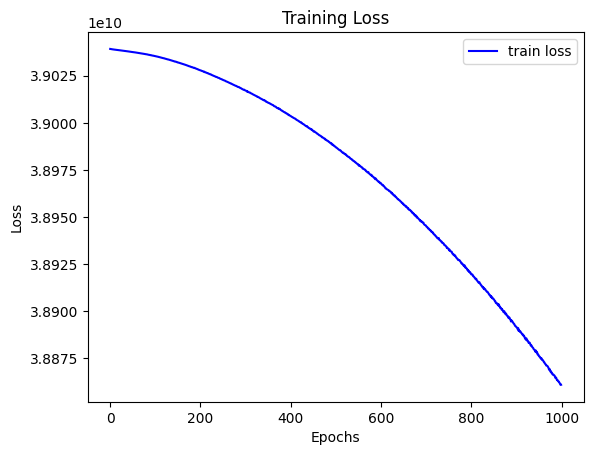

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 读取数据
train_data_path = './data/train.csv'
train = pd.read_csv(train_data_path)

num_of_train_data = train.shape[0]

test_data_path = './data/test.csv'
test = pd.read_csv(test_data_path)

# 房价，要拟合的目标值
target = train.SalePrice

# 输入特征，可以将SalePrice列扔掉
train.drop(['SalePrice'], axis=1, inplace=True)

# 将train和test合并到一起，一块进行特征工程，方便预测test的房价
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'Id'], inplace=True, axis=1)


# 选出非空列
def get_cols_with_no_nans(df, col_type):
    if col_type == 'num':
        predictors = df.select_dtypes(exclude=['object'])
    elif col_type == 'no_num':
        predictors = df.select_dtypes(include=['object'])
    elif col_type == 'all':
        predictors = df
    else:
        print('Error: choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans


num_cols = get_cols_with_no_nans(combined, 'num')
cat_cols = get_cols_with_no_nans(combined, 'no_num')

# 过滤掉含有缺失值的特征
combined = combined[num_cols + cat_cols]

# 对分类特征进行One-Hot编码
def oneHotEncode(df, colNames):
    for col in colNames:
        if df[col].dtype == np.dtype('object'):
            # pandas.get_dummies 可以对分类特征进行One-Hot编码
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies], axis=1)

            # drop the encoded column
            df.drop([col], axis=1, inplace=True)
    return df


combined = oneHotEncode(combined, cat_cols)

# 将combined中的每个元素转换为float类型
combined = combined.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# 训练数据集特征
train_features = torch.tensor(combined[:num_of_train_data].values, dtype=torch.float)
# 训练数据集目标
train_labels = torch.tensor(target.values, dtype=torch.float).view(-1, 1)
# 测试数据集特征
test_features = torch.tensor(combined[num_of_train_data:].values, dtype=torch.float)


# 定义MLP模型
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(num_features=hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(num_features=hidden_dim//2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim // 2, output_dim))

    def forward(self, x):
        out = self.fc(x)
        return out


# 设置超参数
input_dim = train_features.shape[1]
output_dim = 1
hidden_dim = 256
lr = 0.001
num_epochs = 1000

# 初始化模型、损失函数以及优化器
model = Net(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# 记录训练过程的指标
train_losses = []
# 训练MLP模型
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(train_features)
    # 计算损失
    loss = criterion(outputs, train_labels)
    # 反向传播及优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # 每10轮输出一次损失
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

# 绘制训练损失曲线
plt.plot(range(num_epochs), train_losses, 'b-', label='train loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 预测结果
y_pred = model(test_features)
test_pred = y_pred.detach().numpy()

# 生成submission文件
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': test_pred.squeeze()})
submission.to_csv('submission_MLP_with_dropout.csv', index=False)

